# <center> An Introduction to Deep Learning With Python <center/>

### [6.7] Combining CNNs and RNNs to process long sequences
Prof. Yuzo Iano

pgs: 228 - 231

#### Training and evaluating a simple 1D convnet on the Jena data

In [1]:
import os
import numpy as np

In [2]:
data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [3]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
500/500 [==============================] - 39s 77ms/step - loss: 0.4162 - val_loss: 0.4487
Epoch 2/20
500/500 [==============================] - 38s 77ms/step - loss: 0.3576 - val_loss: 0.4349
Epoch 3/20
500/500 [==============================] - 38s 75ms/step - loss: 0.3323 - val_loss: 0.4417
Epoch 4/20
500/500 [==============================] - 40s 80ms/step - loss: 0.3148 - val_loss: 0.4526
Epoch 5/20
500/500 [==============================] - 37s 73ms/step - loss: 0.3003 - val_loss: 0.4532
Epoch 6/20
500/500 [==============================] - 37s 73ms/step - loss: 0.2904 - val_loss: 0.4597
Epoch 7/20
500/500 [==============================] - 36s 72ms/step - loss: 0.2818 - val_loss: 0.4710
Epoch 8/20
500/500 [==============================] - 36s 71ms/step - loss: 0.2751 - val

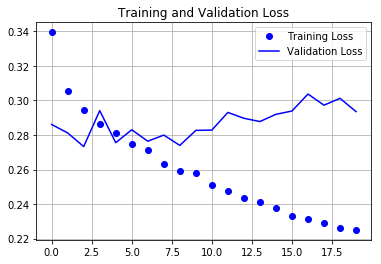

In [8]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

#### Preparing higher-resolution data generators for the Jena dataset

In [5]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

#### Model combining a 1D convolutional base and GRU layer

In [6]:
from keras.layers import GRU

model = Sequential()
model.add(Conv1D(32, 5, activation='relu',input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [===

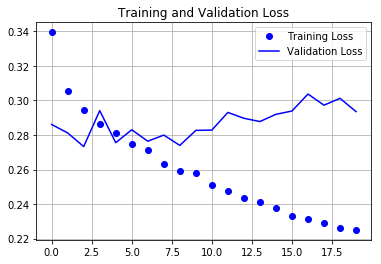

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

###### Pablo Minango
* pablodavid218@gmail.com 